# Dino V2

In [38]:
import sys

INSTALL = True # Switch this to install dependencies
if INSTALL: # Try installing package with extras
    REPO_URL = "https://github.com/facebookresearch/dinov2"
    !{sys.executable} -m pip install -e {REPO_URL}'[extras]' --extra-index-url https://download.pytorch.org/whl/cu117  --extra-index-url https://pypi.nvidia.com
else:
    REPO_PATH = "<FIXME>" # Specify a local path to the repository (or use installed package instead)
    sys.path.append(REPO_PATH)

ERROR: https://github.com/facebookresearch/dinov2[extras] is not a valid editable requirement. It should either be a path to a local project or a VCS URL (beginning with bzr+http, bzr+https, bzr+ssh, bzr+sftp, bzr+ftp, bzr+lp, bzr+file, git+http, git+https, git+ssh, git+git, git+file, hg+file, hg+http, hg+https, hg+ssh, hg+static-http, svn+ssh, svn+http, svn+https, svn+svn, svn+file).

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [40]:
!pip install mmcv-full==1.5.0

  Using cached mmcv_full-1.5.0-py2.py3-none-any.whl
  Attempting uninstall: mmcv-full
    Found existing installation: mmcv-full 1.3.1
    Uninstalling mmcv-full-1.3.1:
      Successfully uninstalled mmcv-full-1.3.1

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [42]:
import warnings

from mmcv.cnn import MODELS as MMCV_MODELS
from mmcv.cnn.bricks.registry import ATTENTION as MMCV_ATTENTION
from mmcv.utils import Registry

MODELS = Registry("models", parent=MMCV_MODELS, scope='xxx')
ATTENTION = Registry("attention", parent=MMCV_ATTENTION, scope='xxx')


BACKBONES = MODELS
NECKS = MODELS
HEADS = MODELS
LOSSES = MODELS
DEPTHER = MODELS


def build_depther(cfg, train_cfg=None, test_cfg=None):
    """Build depther."""
    if train_cfg is not None or test_cfg is not None:
        warnings.warn("train_cfg and test_cfg is deprecated, " "please specify them in model", UserWarning)
    assert cfg.get("train_cfg") is None or train_cfg is None, "train_cfg specified in both outer field and model field "
    assert cfg.get("test_cfg") is None or test_cfg is None, "test_cfg specified in both outer field and model field "
    return DEPTHER.build(cfg, default_args=dict(train_cfg=train_cfg, test_cfg=test_cfg))

In [43]:
import math
import itertools
from functools import partial

import torch
import torch.nn.functional as F

from dinov2.eval.depth.models import build_depther


class CenterPadding(torch.nn.Module):
    def __init__(self, multiple):
        super().__init__()
        self.multiple = multiple

    def _get_pad(self, size):
        new_size = math.ceil(size / self.multiple) * self.multiple
        pad_size = new_size - size
        pad_size_left = pad_size // 2
        pad_size_right = pad_size - pad_size_left
        return pad_size_left, pad_size_right

    @torch.inference_mode()
    def forward(self, x):
        pads = list(itertools.chain.from_iterable(self._get_pad(m) for m in x.shape[:1:-1]))
        output = F.pad(x, pads)
        return output


def create_depther(cfg, backbone_model, backbone_size, head_type):
    train_cfg = cfg.get("train_cfg")
    test_cfg = cfg.get("test_cfg")
    depther = build_depther(cfg.model, train_cfg=train_cfg, test_cfg=test_cfg)

    depther.backbone.forward = partial(
        backbone_model.get_intermediate_layers,
        n=cfg.model.backbone.out_indices,
        reshape=True,
        return_class_token=cfg.model.backbone.output_cls_token,
        norm=cfg.model.backbone.final_norm,
    )

    if hasattr(backbone_model, "patch_size"):
        depther.backbone.register_forward_pre_hook(lambda _, x: CenterPadding(backbone_model.patch_size)(x[0]))

    return depther

In [44]:
# import torch
# import requests
# from pathlib import Path

# # Import dinov2 backbone
# dinov2_vitl14_reg = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14_reg')

# # Import pretrained head for depth estimation
# head_path = './../models/dinov2/dinov2_vitl14_kitti_dpt_head.pth'
# if not Path(head_path).exists():
#     request = requests.get('https://dl.fbaipublicfiles.com/dinov2/dinov2_vitl14/dinov2_vitl14_kitti_dpt_head.pth')
#     with open("./../models/dinov2/dinov2_vitl14_kitti_dpt_head.pth", "wb") as f:
#         f.write(request.content)

Using cache found in /home/nuno/.cache/torch/hub/facebookresearch_dinov2_main


In [53]:
BACKBONE_SIZE = "large" # in ("small", "base", "large" or "giant")


backbone_archs = {
    "small": "vits14",
    "base": "vitb14",
    "large": "vitl14",
    "giant": "vitg14",
}
backbone_arch = backbone_archs[BACKBONE_SIZE]
backbone_name = f"dinov2_{backbone_arch}"

backbone_model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')
backbone_model.eval()
backbone_model.cuda()

Using cache found in /home/nuno/.cache/torch/hub/facebookresearch_dinov2_main
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitl14/dinov2_vitl14_pretrain.pth" to /home/nuno/.cache/torch/hub/checkpoints/dinov2_vitl14_pretrain.pth
100%|██████████| 1.13G/1.13G [02:05<00:00, 9.71MB/s] 


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-23): 24 x NestedTensorBlock(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )


In [54]:
dinov2_vitl14_reg.eval()
dinov2_vitl14_reg.cuda()

DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-23): 24 x NestedTensorBlock(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )


In [69]:
import urllib

import mmcv
from mmcv.runner import load_checkpoint


def load_config_from_url(url: str) -> str:
    with urllib.request.urlopen(url) as f:
        return f.read().decode()


HEAD_DATASET = "nyu" # in ("nyu", "kitti")
HEAD_TYPE = "dpt" # in ("linear", "linear4", "dpt")


DINOV2_BASE_URL = "https://dl.fbaipublicfiles.com/dinov2"
head_config_url = f"{DINOV2_BASE_URL}/{backbone_name}/{backbone_name}_{HEAD_DATASET}_{HEAD_TYPE}_config.py"
head_checkpoint_url = f"{DINOV2_BASE_URL}/{backbone_name}/{backbone_name}_{HEAD_DATASET}_{HEAD_TYPE}_head.pth"

cfg_str = load_config_from_url(head_config_url)
cfg = mmcv.Config.fromstring(cfg_str, file_format=".py")

model = create_depther(
    cfg,
    backbone_model=backbone_model,
    backbone_size=BACKBONE_SIZE,
    head_type=HEAD_TYPE,
)

load_checkpoint(model, head_checkpoint_url, map_location="cpu")
model.eval()
model.cuda()

load checkpoint from http path: https://dl.fbaipublicfiles.com/dinov2/dinov2_vitl14/dinov2_vitl14_nyu_dpt_head.pth


DepthEncoderDecoder(
  (backbone): DinoVisionTransformer()
  (decode_head): DPTHead(
    align_corners=False
    (loss_decode): ModuleList(
      (0): SigLoss()
      (1): GradientLoss()
    )
    (conv_depth): HeadDepth(
      (head): Sequential(
        (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): Interpolate()
        (2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
        (4): Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (relu): ReLU()
    (sigmoid): Sigmoid()
    (reassemble_blocks): ReassembleBlocks(
      (projects): ModuleList(
        (0): ConvModule(
          (conv): Conv2d(1024, 128, kernel_size=(1, 1), stride=(1, 1))
        )
        (1): ConvModule(
          (conv): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
        )
        (2): ConvModule(
          (conv): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1))
        )
        (3): ConvModule(
        

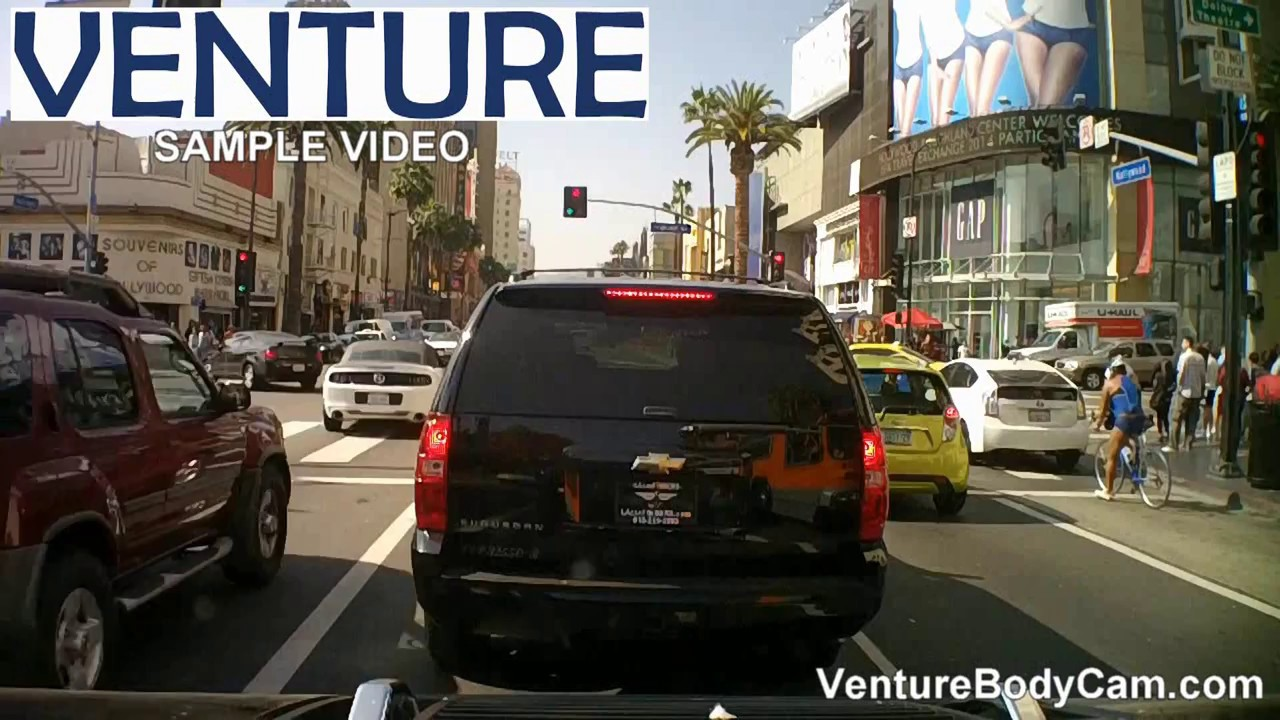

In [72]:
import urllib

from PIL import Image


def load_image_from_url(url: str) -> Image:
    with urllib.request.urlopen(url) as f:
        return Image.open(f).convert("RGB")


# EXAMPLE_IMAGE_URL = "https://dl.fbaipublicfiles.com/dinov2/images/example.jpg"
EXAMPLE_IMAGE_URL = "https://i.ytimg.com/vi/LeYawVc92kg/maxresdefault.jpg"


image = load_image_from_url(EXAMPLE_IMAGE_URL)
display(image)

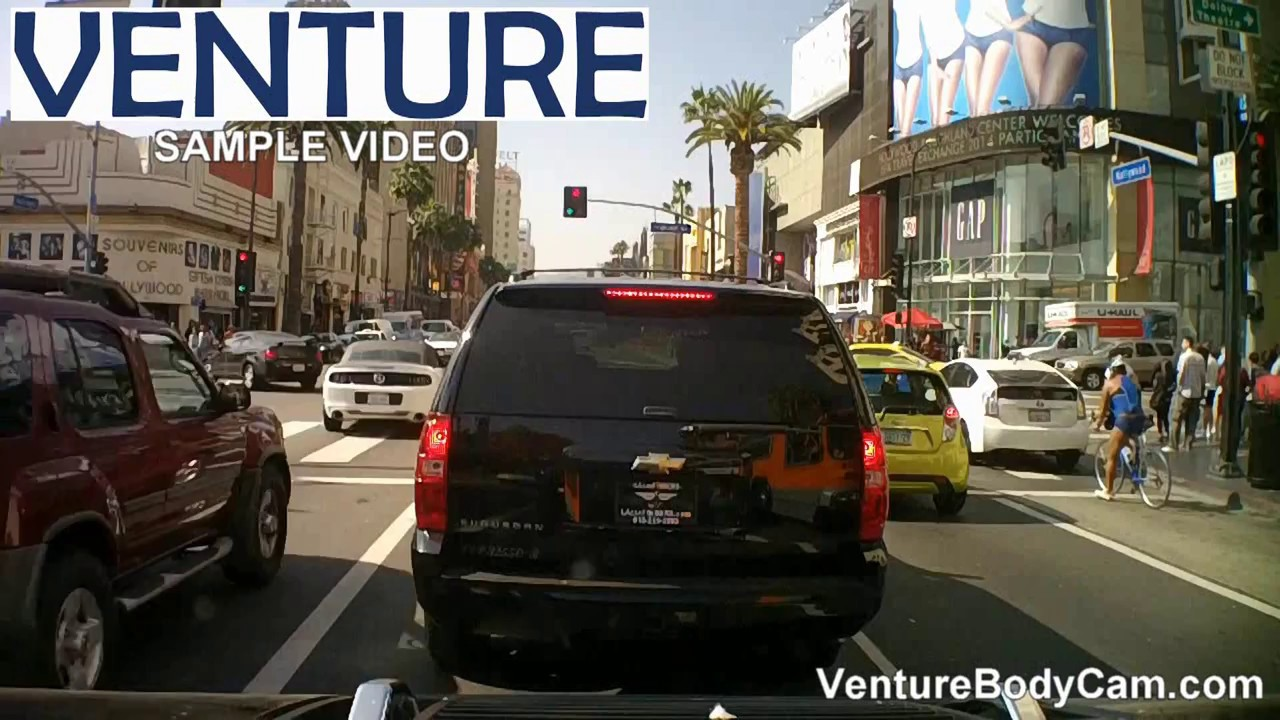

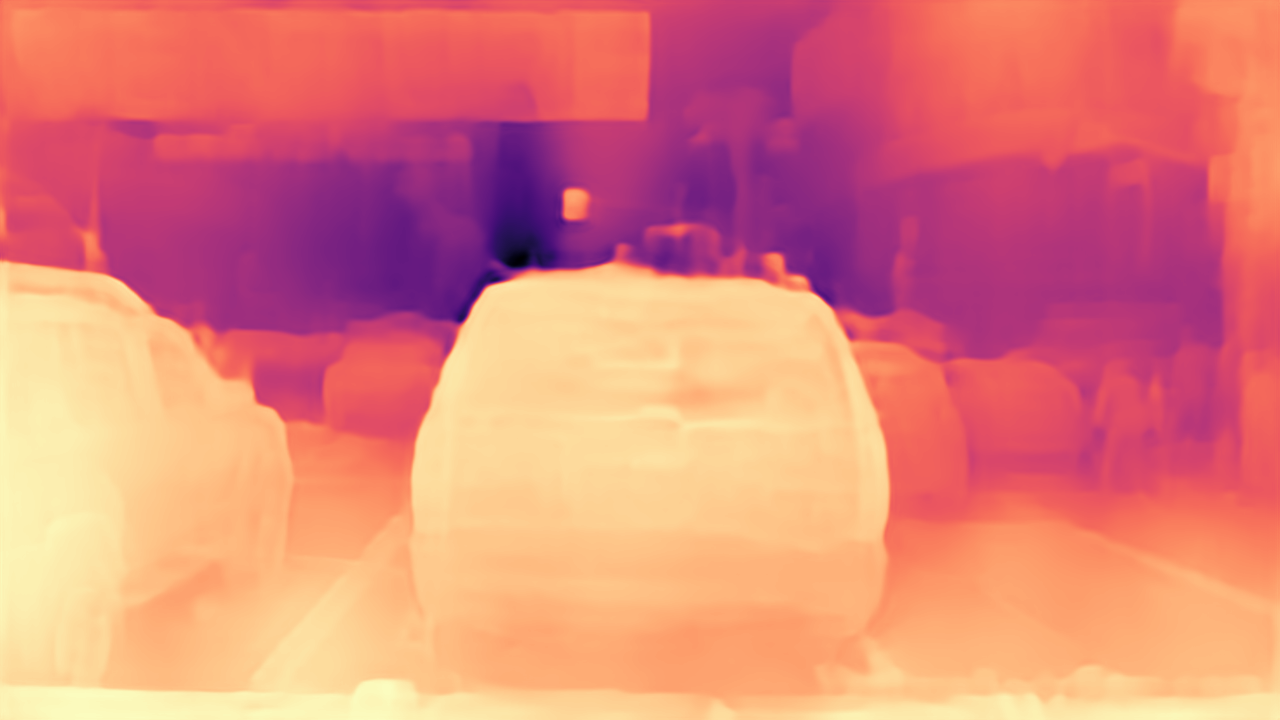

In [73]:
import matplotlib
from torchvision import transforms


def make_depth_transform() -> transforms.Compose:
    return transforms.Compose([
        transforms.ToTensor(),
        lambda x: 255.0 * x[:3], # Discard alpha component and scale by 255
        transforms.Normalize(
            mean=(123.675, 116.28, 103.53),
            std=(58.395, 57.12, 57.375),
        ),
    ])


def render_depth(values, colormap_name="magma_r") -> Image:
    min_value, max_value = values.min(), values.max()
    normalized_values = (values - min_value) / (max_value - min_value)

    colormap = matplotlib.colormaps[colormap_name]
    colors = colormap(normalized_values, bytes=True) # ((1)xhxwx4)
    colors = colors[:, :, :3] # Discard alpha component
    return Image.fromarray(colors)


transform = make_depth_transform()

scale_factor = 1
rescaled_image = image.resize((scale_factor * image.width, scale_factor * image.height))
transformed_image = transform(rescaled_image)
batch = transformed_image.unsqueeze(0).cuda() # Make a batch of one image

with torch.inference_mode():
    result = model.whole_inference(batch, img_meta=None, rescale=True)

depth_image = render_depth(result.squeeze().cpu())
display(image)
display(depth_image)


In [34]:
dinov2_vitl14_reg.state_dict()

OrderedDict([('cls_token',
              tensor([[[-0.0072, -0.0039, -0.0321,  ..., -0.0023,  0.0006, -0.0017]]])),
             ('pos_embed',
              tensor([[[-7.1581e-03, -3.9118e-03, -3.2129e-02,  ..., -2.2904e-03,
                         6.3673e-04, -1.6802e-03],
                       [ 1.2221e-02, -1.8458e-02, -6.7222e-03,  ..., -5.5339e-04,
                        -1.5082e-03, -1.3499e-04],
                       [ 1.2602e-02, -7.5725e-03,  1.1350e-02,  ..., -1.0048e-02,
                        -1.7082e-03,  1.0217e-02],
                       ...,
                       [ 4.7907e-03, -5.3599e-03, -1.1907e-02,  ..., -1.5028e-03,
                        -3.7206e-03, -3.5779e-03],
                       [ 3.0888e-03, -4.7315e-03, -2.6588e-02,  ..., -3.2427e-03,
                        -5.5313e-03,  6.3438e-04],
                       [ 3.1826e-03, -8.4598e-03, -3.9773e-02,  ..., -5.6633e-03,
                        -5.3834e-03,  3.6907e-05]]])),
             ('register_tok

In [3]:
# Load the DPT head weights
dpt_head_weights = torch.load(head_path)

In [37]:
list(dpt_head_weights['state_dict'])

['decode_head.conv_depth.head.0.weight',
 'decode_head.conv_depth.head.0.bias',
 'decode_head.conv_depth.head.2.weight',
 'decode_head.conv_depth.head.2.bias',
 'decode_head.conv_depth.head.4.weight',
 'decode_head.conv_depth.head.4.bias',
 'decode_head.reassemble_blocks.projects.0.conv.weight',
 'decode_head.reassemble_blocks.projects.0.conv.bias',
 'decode_head.reassemble_blocks.projects.1.conv.weight',
 'decode_head.reassemble_blocks.projects.1.conv.bias',
 'decode_head.reassemble_blocks.projects.2.conv.weight',
 'decode_head.reassemble_blocks.projects.2.conv.bias',
 'decode_head.reassemble_blocks.projects.3.conv.weight',
 'decode_head.reassemble_blocks.projects.3.conv.bias',
 'decode_head.reassemble_blocks.resize_layers.0.weight',
 'decode_head.reassemble_blocks.resize_layers.0.bias',
 'decode_head.reassemble_blocks.resize_layers.1.weight',
 'decode_head.reassemble_blocks.resize_layers.1.bias',
 'decode_head.reassemble_blocks.resize_layers.3.weight',
 'decode_head.reassemble_blocks

In [26]:
import torch
import torch.nn as nn

class YourHeadClass(nn.Module):
    def __init__(self, input_features, output_features):
        super(YourHeadClass, self).__init__()
        # Define the layers of the head
        # Example: A simple linear layer to transform the features from the backbone
        self.linear = nn.Linear(input_features, output_features)
        # If the head has more layers, define them here

    def forward(self, x):
        # Define the forward pass
        # Example: Pass the input through the linear layer
        x = self.linear(x)
        # If there are additional layers, add the forward pass operations here
        return x

# Assuming your backbone outputs features of size 1024, and you want the output to be size 100
head = YourHeadClass(input_features=1024, output_features=100)

# Load the state dictionary into the head

head.load_state_dict(dpt_head_weights['state_dict'])

# Attach the head to the backbone
# Replace this with the actual attribute name of the head in your backbone model
backbone.head = head


RuntimeError: Error(s) in loading state_dict for YourHeadClass:
	Missing key(s) in state_dict: "linear.weight", "linear.bias". 
	Unexpected key(s) in state_dict: "decode_head.conv_depth.head.0.weight", "decode_head.conv_depth.head.0.bias", "decode_head.conv_depth.head.2.weight", "decode_head.conv_depth.head.2.bias", "decode_head.conv_depth.head.4.weight", "decode_head.conv_depth.head.4.bias", "decode_head.reassemble_blocks.projects.0.conv.weight", "decode_head.reassemble_blocks.projects.0.conv.bias", "decode_head.reassemble_blocks.projects.1.conv.weight", "decode_head.reassemble_blocks.projects.1.conv.bias", "decode_head.reassemble_blocks.projects.2.conv.weight", "decode_head.reassemble_blocks.projects.2.conv.bias", "decode_head.reassemble_blocks.projects.3.conv.weight", "decode_head.reassemble_blocks.projects.3.conv.bias", "decode_head.reassemble_blocks.resize_layers.0.weight", "decode_head.reassemble_blocks.resize_layers.0.bias", "decode_head.reassemble_blocks.resize_layers.1.weight", "decode_head.reassemble_blocks.resize_layers.1.bias", "decode_head.reassemble_blocks.resize_layers.3.weight", "decode_head.reassemble_blocks.resize_layers.3.bias", "decode_head.reassemble_blocks.readout_projects.0.0.weight", "decode_head.reassemble_blocks.readout_projects.0.0.bias", "decode_head.reassemble_blocks.readout_projects.1.0.weight", "decode_head.reassemble_blocks.readout_projects.1.0.bias", "decode_head.reassemble_blocks.readout_projects.2.0.weight", "decode_head.reassemble_blocks.readout_projects.2.0.bias", "decode_head.reassemble_blocks.readout_projects.3.0.weight", "decode_head.reassemble_blocks.readout_projects.3.0.bias", "decode_head.convs.0.conv.weight", "decode_head.convs.1.conv.weight", "decode_head.convs.2.conv.weight", "decode_head.convs.3.conv.weight", "decode_head.fusion_blocks.0.project.conv.weight", "decode_head.fusion_blocks.0.project.conv.bias", "decode_head.fusion_blocks.0.res_conv_unit2.conv1.conv.weight", "decode_head.fusion_blocks.0.res_conv_unit2.conv2.conv.weight", "decode_head.fusion_blocks.1.project.conv.weight", "decode_head.fusion_blocks.1.project.conv.bias", "decode_head.fusion_blocks.1.res_conv_unit1.conv1.conv.weight", "decode_head.fusion_blocks.1.res_conv_unit1.conv2.conv.weight", "decode_head.fusion_blocks.1.res_conv_unit2.conv1.conv.weight", "decode_head.fusion_blocks.1.res_conv_unit2.conv2.conv.weight", "decode_head.fusion_blocks.2.project.conv.weight", "decode_head.fusion_blocks.2.project.conv.bias", "decode_head.fusion_blocks.2.res_conv_unit1.conv1.conv.weight", "decode_head.fusion_blocks.2.res_conv_unit1.conv2.conv.weight", "decode_head.fusion_blocks.2.res_conv_unit2.conv1.conv.weight", "decode_head.fusion_blocks.2.res_conv_unit2.conv2.conv.weight", "decode_head.fusion_blocks.3.project.conv.weight", "decode_head.fusion_blocks.3.project.conv.bias", "decode_head.fusion_blocks.3.res_conv_unit1.conv1.conv.weight", "decode_head.fusion_blocks.3.res_conv_unit1.conv2.conv.weight", "decode_head.fusion_blocks.3.res_conv_unit2.conv1.conv.weight", "decode_head.fusion_blocks.3.res_conv_unit2.conv2.conv.weight", "decode_head.project.conv.weight", "decode_head.project.conv.bias". 

In [ ]:
import torch

# Load the backbone model
backbone = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14_reg')

# Load the backbone's weights (if not already loaded by the hub.load method)
# backbone.load_state_dict(torch.load('path_to_backbone_checkpoint.pth'))

# Load the head model (assuming you have a class or a function to create it)
# head = YourHeadClass()

# Load the head's weights
head_weights = torch.load('path_to_head_checkpoint.pth')['state_dict']

# If the head is a PyTorch nn.Module with properly named parameters, you can load the state_dict directly
# head.load_state_dict(head_weights)

# Now attach the head to the backbone
# This step is highly dependent on the specific models you're working with
# For example, if you're supposed to replace the last layer of the backbone:
# backbone.head = head

# Or if the head is to be added as a new module:
# backbone.add_module('dpt_head', head)

# Now the model is combined, and you can use it for inference or further training


## With trainable head

## Depth Estimation

In [ ]:
# Load the DPT head weights
dpt_head_weights = torch.load(head_path)

dpt_head_weights

In [ ]:
dinov2_vitl14_reg.head.state_dict(dpt_head_weights)

In [ ]:
dinov2_vitl14_reg

# Grounding Dino + Segment anything

# Yolov8

# Exploration

In [ ]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"


In [ ]:
dinov2_vitg14_reg = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14_reg')
dinov2_vitg14_reg.eval()

In [ ]:
from torchvision import transforms

image_transforms = transforms.Compose([
    transforms.Resize(256, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

In [ ]:
import torchinfo 
from torchinfo import summary

# summary(dinov2_vitg14_reg,
#         input_size = image_transforms(img).size(),
#         col_names=["num_params", "trainable"],
#         )

summary_list = summary(dinov2_vitg14_reg,
        col_names=["num_params", "trainable"],
        )
summary_list

In [ ]:
next(dinov2_vitg14_reg.parameters())

In [ ]:
from PIL import Image

# 2. Open image
img = Image.open(dataroot_img/'samples/CAM_BACK/n003-2018-01-03-12-03-23+0800__CAM_BACK__1514952316316487.jpg')
img = image_transforms(img).unsqueeze(0)  # Add batch dimension

In [ ]:
# Perform inference
with torch.no_grad():
    outputs = dinov2_vitg14_reg(img)

In [ ]:
# Since DINOv2 is primarily for feature extraction, it doesn't provide direct segmentation
# You might need additional steps to derive segmentation from the features
features = outputs[0]

In [ ]:
# For classification, assuming a linear layer on top of the extracted features
# Replace this with your classification head if you have a different setup
classifier = torch.nn.Linear(features.shape[1], 6)  # num_classes is the number of classes in your dataset
classification_logits = classifier(features)

# Post-process the classification output
classification_scores = torch.nn.functional.softmax(classification_logits, dim=1)

# Convert to numpy arrays or other formats as needed
classification_scores = classification_scores.numpy()

# Process these outputs as needed for your application

In [ ]:
res_img = dinov2_vitg14_reg(img).detach().numpy()

In [ ]:
dinov2_vitg14_reg(image_transforms(img).unsqueeze(0)).size()